## Chapter 1.2: Data Structure and Manipulation
***
In the previous tutorial we saw how we can create a model by calling a few lines of code from imported data. However modelling tends to be an iterative process. Here we will explore the tools that `GemPy` with the help of `pandas` offers to modify the input data of a model.

There is 5 main  funtion "types" in GemPy:

- *create*: 
    - create new objects
    - return the objects
 
- *set*
    - set given values **inplace**

- *update*
    - update dataframe or other attribute from other object or many objects. Usually this object is not passed as argument (this is the main difference with map)

- *map*
    - update dataframe (so far mainly df) or other attribute from an object to another object.
    - Completelly directed. One attribute/property is updated by another one.
    - In general, we map_from so the method is in the mutated object.

- *get*
    - return an image of the object
    
The intention is that a function/method that does not fall in any of these categories has a name (verb in principle) self explanatory. 


As always we start importing the usual packages and reading expample data:

<p align="center"><iframe src="https://atlas.mindmup.com/2018/11/ca2c3230ddc511e887555f7d8bb30b4d/gempy_mind_map/index.html"></iframe></p>


In [1]:
from IPython.display import IFrame    
IFrame("https://atlas.mindmup.com/2018/11/ca2c3230ddc511e887555f7d8bb30b4d/gempy_mind_map/index.html",
      width=1000, height=1000)

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

# Importing the data from CSV-files and setting extent and resolution
geo_model = gp.create_data([0,2000.,0,2000.,0,2000.],[20,20,20], 
      path_o = os.pardir+"/input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = os.pardir+"/input_data/tut_chapter1/simple_fault_model_points.csv") 

../../gempy/core/gempy_front.py:668: FutureWarning: create_data will get deprecated in the next version of gempy. It still exist only to keepthe behaviour equal to older version. Use init_data.
  "the behaviour equal to older version. Use init_data.", FutureWarning)


[False]


../../gempy/core/data.py:1532: RuntimeWarning: overflow encountered in double_scalars
  (extent[2] - extent[3]) ** 2 +


No id or order_series in the input
Length of formation_names does not match number of formations. Too many.
Empty DataFrame
Columns: [formation, series, id, isBasement]
Index: []
     formation series   id isBasement
0        Shale    NaN  NaN        NaN
1  Sandstone_1    NaN  NaN        NaN
2    Siltstone    NaN  NaN        NaN
3  Sandstone_2    NaN  NaN        NaN
4   Main_Fault    NaN  NaN        NaN
[False]


In [3]:
geo_model.formations

,formation,series,id,isBasement
0,Shale,Default series,1,False
1,Sandstone_1,Default series,2,False
2,Siltstone,Default series,3,False
3,Sandstone_2,Default series,4,False
4,Main_Fault,Default series,5,False
5,basement,NaN,6,True


In [4]:
geo_model.series

,order_series,BottomRelation
Default series,NaN,NaN


In [5]:
geo_model.faults

,isFault,isFinite
Default series,False,NaN


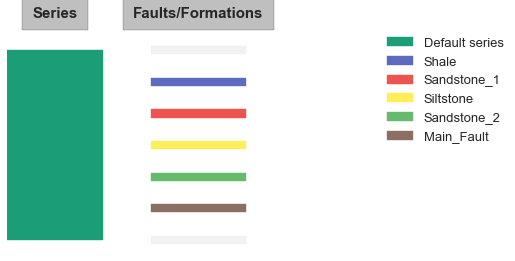

In [5]:
a = gp.StratigraphicPile(geo_model.series, geo_model.formations.df)
a.figure

In [6]:
d =  {"Fault_Series":'Main_Fault', 
                                  "Strat_Series": ('Sandstone_2','Siltstone',
                                  'Shale', 'Sandstone_1')}

In [7]:
geo_model.formations.map_series(d)

In [8]:
series_idx = geo_model.series.df.index.set_categories(d.keys(), rename=True)
# If order, it has to go here
order_series = ["Fault_Series", 'Strat_Series']
# ----------------------------
geo_model.series.df.index =  series_idx
geo_model.faults.df.index =  series_idx
geo_model.faults.faults_relations_df.index = series_idx
geo_model.faults.faults_relations_df.columns = series_idx

In [10]:
geo_model.faults.faults_relations_df

,Fault_Series
Fault_Series,False


In [9]:
# Add series
for c in d.keys():
    geo_model.series.df.loc[c] = np.nan
    geo_model.faults.df.loc[c, 'isFault'] = np.nan
    geo_model.faults.faults_relations_df.loc[c,c] = np.nan
  #  geo_model.faults.faults_relations_df[c, c] = False

In [10]:
geo_model.series.update_order_series()
geo_model.series


,order_series,BottomRelation
Fault_Series,1,NaN
Strat_Series,2,NaN


In [11]:
geo_model.faults
geo_model.faults.set_is_fault()

[ True False]


,isFault,isFinite
Fault_Series,True,NaN
Strat_Series,False,NaN


In [12]:
geo_model.faults.faults_relations_df

,Fault_Series,Strat_Series
Fault_Series,NaN,NaN
Strat_Series,NaN,NaN


In [13]:
f = geo_model.formations.df['formation']
f.sort_values()

4     Main_Fault
1    Sandstone_1
3    Sandstone_2
0          Shale
2      Siltstone
5       basement
Name: formation, dtype: category
Categories (6, object): [Main_Fault, Sandstone_1, Sandstone_2, Shale, Siltstone, basement]

In [14]:
order_formations=['Main_Fault', 'Sandstone_2','Siltstone','Shale', 'Sandstone_1', 'basement']
geo_model.formations.df['formation'].cat.reorder_categories(order_formations, inplace=True)

In [15]:
geo_model.formations.df.sort_values(['formation'], inplace=True)
geo_model.formations.df.reset_index(drop=True, inplace=True)
geo_model.formations.set_id()

,formation,series,id,isBasement
0,Main_Fault,Fault_Series,1,False
1,Sandstone_2,Strat_Series,2,False
2,Siltstone,Strat_Series,3,False
3,Shale,Strat_Series,4,False
4,Sandstone_1,Strat_Series,5,False
5,basement,NaN,6,True


In [16]:
geo_model.formations

,formation,series,id,isBasement
0,Main_Fault,Fault_Series,1,False
1,Sandstone_2,Strat_Series,2,False
2,Siltstone,Strat_Series,3,False
3,Shale,Strat_Series,4,False
4,Sandstone_1,Strat_Series,5,False
5,basement,NaN,6,True


In [17]:
# # Assigning series to formations as well as their order (timewise)
# gp.set_series(geo_model, {"Fault_Series":'Main_Fault', 
#                          "Strat_Series": ('Sandstone_2','Siltstone',
#                                           'Shale', 'Sandstone_1')},
#                        order_series = ["Fault_Series", 'Strat_Series'],
#                        order_formations=['Main_Fault', 
#                                          'Sandstone_2','Siltstone',
#                                          'Shale', 'Sandstone_1',
#                                          ], verbose=1) 

In [18]:
gp.map_to_data(geo_model, geo_model.series, geo_model.formations, geo_model.faults)

In [19]:
geo_model.interfaces.sort_table()
geo_model.orientations.sort_table()
geo_model.interfaces

,X,Y,Z,formation,series,id,order_series,isFault,X_r,Y_r,Z_r
52,700.0,1000.0,900.0,Main_Fault,Fault_Series,1,1,True,0.460626,0.500100,0.500100
53,600.0,1000.0,600.0,Main_Fault,Fault_Series,1,1,True,0.434311,0.500100,0.421153
54,500.0,1000.0,300.0,Main_Fault,Fault_Series,1,1,True,0.407995,0.500100,0.342205
55,800.0,1000.0,1200.0,Main_Fault,Fault_Series,1,1,True,0.486942,0.500100,0.579047
56,900.0,1000.0,1500.0,Main_Fault,Fault_Series,1,1,True,0.513258,0.500100,0.657995
44,0.0,1000.0,1500.0,Sandstone_2,Strat_Series,2,2,False,0.276416,0.500100,0.657995
45,300.0,1000.0,1400.0,Sandstone_2,Strat_Series,2,2,False,0.355363,0.500100,0.631679
46,600.0,1000.0,1300.0,Sandstone_2,Strat_Series,2,2,False,0.434311,0.500100,0.605363
47,1100.0,1000.0,1300.0,Sandstone_2,Strat_Series,2,2,False,0.565889,0.500100,0.605363
48,1400.0,1000.0,1250.0,Sandstone_2,Strat_Series,2,2,False,0.644837,0.500100,0.592205


In [20]:
geo_model.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,id,order_series,isFault,X_r,Y_r,Z_r
2,500.0,1000.0,864.602,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Fault_Series,1,1,True,0.407995,0.5001,0.490785
1,400.0,1000.0,1400.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Strat_Series,2,2,False,0.381679,0.5001,0.631679
0,1000.0,1000.0,950.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Strat_Series,4,2,False,0.539574,0.5001,0.513258


The class `gempy.core.model.Model` works as the parent container of our project. Therefore the main step of any project is to create an instance of this class. In the official documentation we use normally geo_model (geo_data in the past) as name of this instance.

When we instiantiate a `Model` object we full data structure is created. By using `gp.init_data` and `set_series` we set the default values -- given the attributes -- to all of fields. Data is stored in pandas dataframes. With `gp.get_data` and the name of the data object it is possible to have access to the dataframes: 

`str`['all', 'interfaces', 'orientations', 'formations', 'series', 'faults', 'faults_relations', 
        additional data]
        
These dataframes are stored in specific objects. These objects contain the specific methods to manipulate them. You access these objects with the spectific getter or as a attribute of `Model`

### Formations:

The *df* formation contain two properties. *id* refers to the order of the formation on the sequential pile, i.e. the strict order of computation. *values* on the other hand is the final value that each voxel will have after discretization. This may be useful for example in the case we want to map a specific geophysical property (such as density) to a given unity. By default both are the same since to discretize lithological units the value is arbitrary.

In [21]:
formation = gp.get_formations(geo_model)

Alternatively we can access the dataframe by:

In [22]:
gp.get_data(geo_model, 'formations')

,formation,series,id,isBasement
0,Main_Fault,Fault_Series,1,False
1,Sandstone_2,Strat_Series,2,False
2,Siltstone,Strat_Series,3,False
3,Shale,Strat_Series,4,False
4,Sandstone_1,Strat_Series,5,False
5,basement,NaN,6,True


In [25]:
geo_model.formations.df['series']

0    Fault_Series
1    Strat_Series
2    Strat_Series
3    Strat_Series
4    Strat_Series
5             NaN
Name: series, dtype: object

In [26]:
geo_model.formations.set_formation_names(['foo', 'foo2', 'foo3', 'foo4', 'foo5', 'foo6', 'foo7'])

Length of formation_names does not match number of formations. Too many.
     formation        series  id  isBasement
0   Main_Fault  Fault_Series   1       False
1  Sandstone_2  Strat_Series   2       False
2    Siltstone  Strat_Series   3       False
3        Shale  Strat_Series   4       False
4  Sandstone_1  Strat_Series   5       False
5     basement           NaN   6        True
     formation        series   id isBasement
0   Main_Fault  Fault_Series  1.0      False
1  Sandstone_2  Strat_Series  2.0      False
2    Siltstone  Strat_Series  3.0      False
3        Shale  Strat_Series  4.0      False
4  Sandstone_1  Strat_Series  5.0      False
5     basement           NaN  6.0       True
0          foo           NaN  NaN        NaN
1         foo2           NaN  NaN        NaN
2         foo3           NaN  NaN        NaN
3         foo4           NaN  NaN        NaN
4         foo5           NaN  NaN        NaN
5         foo6           NaN  NaN        NaN
6         foo7           Na

In [27]:
geo_model.formations.set_id()

,formation,series,id,isBasement
0,Main_Fault,Fault_Series,1,False
1,Sandstone_2,Strat_Series,2,False
2,Siltstone,Strat_Series,3,False
3,Shale,Strat_Series,4,False
4,Sandstone_1,Strat_Series,5,False
5,basement,Default series,6,True
0,foo,Default series,1,NaN
1,foo2,Default series,2,NaN
2,foo3,Default series,3,NaN
3,foo4,Default series,4,NaN


In [28]:
geo_model.formations.df['series'] = geo_model.formations.df['series'].astype('category')

In [29]:
geo_model.formations.df.drop(geo_model.formations.df.index[geo_model.formations.df['formation'] == 'foo4'])

,formation,series,id,isBasement
0,Main_Fault,Fault_Series,1,False
1,Sandstone_2,Strat_Series,2,False
2,Siltstone,Strat_Series,3,False
4,Sandstone_1,Strat_Series,5,False
5,basement,Default series,6,True
0,foo,Default series,1,NaN
1,foo2,Default series,2,NaN
2,foo3,Default series,3,NaN
4,foo5,Default series,5,NaN
5,foo6,Default series,6,NaN


In [30]:
fdf = geo_model.formations.df


In [31]:
f2

NameError: name 'f2' is not defined

In [32]:
f2 = f['formation']
#f2.cat.add_categories('Siltstone', inplace=True)
#2.('Siltstone')
f.loc[4, 'formation'] = 'Siltstone'

KeyError: 'formation'

In [33]:
f

0          Shale
1    Sandstone_1
2      Siltstone
3    Sandstone_2
4     Main_Fault
5       basement
Name: formation, dtype: category
Categories (6, object): [Main_Fault, Sandstone_2, Siltstone, Shale, Sandstone_1, basement]

In [34]:
f['formation'].map(series.categories_df['Strat_Series'])

KeyError: 'formation'

In [63]:
pn.get_dummies(series.categories_df)

,Fault_Series_Main_Fault,Strat_Series_Sandstone_1,Strat_Series_Sandstone_2,Strat_Series_Shale,Strat_Series_Siltstone
0,1,0,1,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,0,1,0,0,0


In [ ]:
f['formation'].map()

In [17]:
f['formation'].map({'foo2':'a'})

0    NaN
1      a
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
Name: formation, dtype: object

In [ ]:
f['series'].map

In [110]:
np.any(f.index.isin([6]))

True

In [ ]:
f.rename(index={5:10}, inplace=True)

In [107]:
f.sort_index()

,formation,series,id,isBasement
0,foo,Fault_Series,1.0,0.0
1,foo2,Fault_Series,2.0,0.0
2,foo3,Fault_Series,3.0,0.0
3,foo4,Fault_Series,4.0,0.0
4,foo5,Fault_Series,5.0,0.0
6,foo7,Fault_Series,7.0,1.0
7,7,7,7.0,7.0
9,lala,NaN,NaN,NaN
10,foo6,Fault_Series,6.0,0.0


In [93]:
geo_model.formations.df.loc[9, 'formation'] = 'lala'

In [96]:
s = geo_model.formations.df['series']

In [ ]:
s.sort_values()

In [35]:
geo_model.formations.df['series']

0      Fault_Series
1      Strat_Series
2      Strat_Series
3      Strat_Series
4      Strat_Series
5    Default series
0    Default series
1    Default series
2    Default series
3    Default series
4    Default series
5    Default series
6    Default series
Name: series, dtype: category
Categories (3, object): [Default series, Fault_Series, Strat_Series]

### Series

In [36]:
series = gp.get_series(geo_model)
series.df

,order_series,BottomRelation
Fault_Series,1,NaN
Strat_Series,2,NaN


In [37]:
series.df.index.codes

array([0, 1], dtype=int8)

In [38]:
a = pn.DataFrame(index=pn.CategoricalIndex(series.categories_df.columns
                                           ,ordered=True), columns= ['values', 'order'])

In [39]:
a.index = a.index.add_categories('foo')

In [40]:
a

,values,order
Default series,NaN,NaN


In [41]:
a.loc['foo'] = 4

In [42]:
a.index=a.index.reorder_categories(['foo', 'Strat_Series', 'Fault_Series'])

ValueError: items in new_categories are not the same as in old categories

In [43]:
a.index = a.index.sort_values()

In [44]:
a

,values,order
Default series,NaN,NaN
foo,4,4


In [45]:
a.drop('foo')

,values,order
Default series,NaN,NaN


In [46]:
gp.get_data(geo_model, 'series')

,order_series,BottomRelation
Fault_Series,1,NaN
Strat_Series,2,NaN


In [47]:
geo_model.series.categories_df

,Default series
0,None
1,basement


### Faults

The *df faults* is used to charectirize which *mathematical series* behave as fault and if mentioned faults are finite or infinite:

In [48]:
gp.get_faults(geo_model)

,isFault,isFinite
Fault_Series,True,NaN
Strat_Series,False,NaN


In [49]:
gp.get_data(geo_model, 'faults')

,isFault,isFinite
Fault_Series,True,NaN
Strat_Series,False,NaN


Finally we have the *faults relations df* which captures which *mathematical series* a given fault offset in order to reproduce complex faulting networks

In [50]:
gp.get_data(geo_model, 'faults_relations_df')

,Fault_Series,Strat_Series
Fault_Series,NaN,NaN
Strat_Series,NaN,NaN


### Additional Data

In [51]:
gp.get_additional_data(geo_model)

values
Structure isLith                                                                     True
          isFault                                                                   False
          number faults                                                                 0
          number formations                                                             6
          number formations per series                                                 []
          len formations interfaces                                    [16, 15, 13, 8, 5]
          len series interfaces                                                       [0]
          len series orientations                                                      []
Options   dtype                                                                   float64
          output                                                                  geology
          theano_optimizer                                                   fast_compile
          device                                                                      cpu
          verbosity                                                                   NaN
Kringing  range                                                                    3464.1
          $C_o$                                                                    285714
          drift equations                                                             [0]
          nugget grad                                                                0.01
          nugget scalar                                                             1e-06
Rescaling rescaling factor                                                           3800
          centers                       X     850.0
Y    1000.0
Z     900.0
dtype: flo...

In [52]:
gp.get_data(geo_model, 'additional data')

values
Structure isLith                                                                     True
          isFault                                                                   False
          number faults                                                                 0
          number formations                                                             6
          number formations per series                                                 []
          len formations interfaces                                    [16, 15, 13, 8, 5]
          len series interfaces                                                       [0]
          len series orientations                                                      []
Options   dtype                                                                   float64
          output                                                                  geology
          theano_optimizer                                                   fast_compile
          device                                                                      cpu
          verbosity                                                                   NaN
Kringing  range                                                                    3464.1
          $C_o$                                                                    285714
          drift equations                                                             [0]
          nugget grad                                                                0.01
          nugget scalar                                                             1e-06
Rescaling rescaling factor                                                           3800
          centers                       X     850.0
Y    1000.0
Z     900.0
dtype: flo...

###  Interfaces

These two DataFrames (df from now on) will contain the individual information of each point at an interface or orientation. Some properties of this table are mapped from the *df* below.

In [53]:
gp.get_data(geo_model, 'interfaces').head()

,X,Y,Z,formation,series,id,order_series,isFault
52,700.0,1000.0,900.0,Main_Fault,Fault_Series,1,1,True
53,600.0,1000.0,600.0,Main_Fault,Fault_Series,1,1,True
54,500.0,1000.0,300.0,Main_Fault,Fault_Series,1,1,True
55,800.0,1000.0,1200.0,Main_Fault,Fault_Series,1,1,True
56,900.0,1000.0,1500.0,Main_Fault,Fault_Series,1,1,True


### Orientations

In [54]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,id,order_series,isFault
2,500.0,1000.0,864.602,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Fault_Series,1,1,True
1,400.0,1000.0,1400.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Strat_Series,2,2,False
0,1000.0,1000.0,950.000,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Strat_Series,4,2,False


These objects contain and represent all necessary data to create a model.

### Adding, modifing deleting

In [55]:
geo_model.modify_interfaces([0], X=[2000], Y=[2000], Z=[2000])

#### Passing a vtk object to real time update

In [56]:
v = gp.plot.plot_data_3D(geo_model)

In [57]:
isinstance(v, gp.plot.vtkPlot)

True

In [58]:
geo_model.modify_interfaces([0], v,  X=[2000], Y=[2000], Z=[1000])

In [59]:
v.close()

##### Real time surface updating


In [23]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run')

Compiling theano function...


/anaconda3/lib/python3.6/site-packages/Theano-1.0.1-py3.6.egg/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of df:  1


,values
dtype,float64
output,geology
theano_optimizer,fast_run
device,cpu
verbosity,NaN


In [24]:
gp.compute_model(geo_model)


Lithology ids 
  [6. 6. 6. ... 2. 2. 2.] 
Lithology scalar field 
  [30.32253075 30.34951782 30.37647057 ... 30.97820663 31.01681709
 31.0546608 ] 
Fault block 
  [[1. 1. 1. ... 2. 2. 2.]]

In [ ]:
gp.plot.plot_section(geo_model, 10, plot_data=True)

In [25]:
gp.save_model(geo_model, './saves/ch1-2')

True

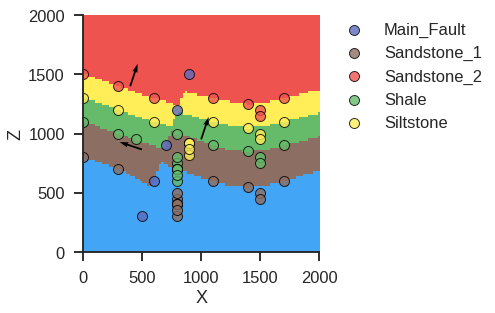

In [4]:
gp.plot.plot_section(geo_model, 50, plot_data=True)

In [5]:
v = gp.plot.plot_surfaces_3D_real_time(geo_model, None, None)

holding... Use vtk.resume to go back to the interactive window


In [12]:
geo_model.modify_interfaces([0], v,  X=[2000], Y=[2000], Z=[1000])

In [14]:
v.close()

### Modify other dataframes

In [47]:
geo_model.additional_data.kriging_data

,values
range,3464.1
$C_o$,285714
drift equations,"[3, 3]"
nugget grad,3
nugget scalar,3


In [11]:
geo_model.additional_data.kriging_data.loc[['nugget scalar', 'nugget grad'], 'values'] = [1000,1000]
geo_model.interpolator.set_theano_shared_kriging()


In [6]:
geo_model.additional_data.kriging_data.loc[['nugget scalar', 'nugget grad'], 'values'] = [1000,3]

In [70]:
geo_model.additional_data.kriging_data.loc['nugget scalar', 'values'] = 1e-6
geo_model.additional_data.kriging_data.loc['nugget grad', 'values'] = 0.01

In [38]:
geo_model.additional_data.kriging_data.loc['nugget scalar', 'values'] = 1
geo_model.additional_data.kriging_data.loc['nugget grad', 'values'] = 1

In [10]:
geo_model.interpolator.set_theano_shared_kriging()
v.vv.update_surfaces_real_time()
v.vv.interactor.Render()

In [62]:
geo_model.save_model()

True